# Experiments

In [ ]:
import os
import IPython.display as ipd

for filename in os.listdir('./test'):
    ipd.Audio('./test/' + filename)

In [ ]:
import os
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf

for filename in os.listdir('./test'):
    data, sampling_rate = librosa.load('./test/' + filename)

    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
import speech_recognition as sr

In [ ]:
r = sr.Recognizer()

In [ ]:
zero = sr.AudioFile('0_jackson_2.wav')

In [ ]:
with zero as source:
    audio = r.record(source)

In [ ]:
print(r.recognize_google(audio))

# This is the main training part:

## training with audio files

In [1]:
#imports:

from export_model import *
from preprocess import *
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [16]:
%load_ext autoreload
%autoreload 2

#from preprocess import *
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
#from keras.utils import to_categorical
#from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from sklearn.preprocessing import LabelEncoder
#import itertools

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
#defaults at the end
feature_dim_1 = 20   #20
channel = 1          #1
epochs = 50         #50
batch_size = 100     #100
verbose = 1          #1
# change num_classes depending on the amount of labels
num_classes = 12

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Saving vectors of label - '9': 100%|█████████████████████████████████████████████████| 139/139 [00:02<00:00, 50.44it/s]


## model & prediction

In [17]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [18]:
model = get_model()
history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 1283 samples, validate on 856 samples
Epoch 1/150
1283/1283 [==============================] - ETA: 12s - loss: 6.3801 - acc: 0.14 - ETA: 6s - loss: 5.6404 - acc: 0.1050 - ETA: 4s - loss: 4.7495 - acc: 0.130 - ETA: 3s - loss: 4.3157 - acc: 0.132 - ETA: 2s - loss: 4.0765 - acc: 0.126 - ETA: 2s - loss: 3.8730 - acc: 0.126 - ETA: 1s - loss: 3.6873 - acc: 0.131 - ETA: 1s - loss: 3.5158 - acc: 0.137 - ETA: 1s - loss: 3.3894 - acc: 0.140 - ETA: 0s - loss: 3.2920 - acc: 0.144 - ETA: 0s - loss: 3.2029 - acc: 0.149 - ETA: 0s - loss: 3.1194 - acc: 0.155 - 4s 3ms/step - loss: 3.0718 - acc: 0.1543 - val_loss: 1.9908 - val_acc: 0.4100
Epoch 2/150
1283/1283 [==============================] - ETA: 1s - loss: 2.2527 - acc: 0.280 - ETA: 1s - loss: 2.2436 - acc: 0.250 - ETA: 1s - loss: 2.1777 - acc: 0.273 - ETA: 1s - loss: 2.1515 - acc: 0.275 - ETA: 1s - loss: 2.1085 - acc: 0.296 - ETA: 1s - loss: 2.0578 - acc: 0.308 - ETA: 1s - loss: 2.0158 - acc: 0.320 - ETA: 0s - loss: 1.9884 - acc: 0.330 - 

1283/1283 [==============================] - ETA: 2s - loss: 0.3078 - acc: 0.870 - ETA: 1s - loss: 0.3508 - acc: 0.860 - ETA: 1s - loss: 0.3289 - acc: 0.866 - ETA: 1s - loss: 0.3199 - acc: 0.885 - ETA: 1s - loss: 0.3187 - acc: 0.886 - ETA: 1s - loss: 0.3350 - acc: 0.881 - ETA: 1s - loss: 0.3323 - acc: 0.882 - ETA: 0s - loss: 0.3226 - acc: 0.883 - ETA: 0s - loss: 0.3150 - acc: 0.888 - ETA: 0s - loss: 0.3104 - acc: 0.891 - ETA: 0s - loss: 0.3010 - acc: 0.895 - ETA: 0s - loss: 0.2911 - acc: 0.898 - 3s 2ms/step - loss: 0.2859 - acc: 0.8979 - val_loss: 0.2496 - val_acc: 0.9089
Epoch 15/150
1283/1283 [==============================] - ETA: 1s - loss: 0.3206 - acc: 0.910 - ETA: 1s - loss: 0.2948 - acc: 0.910 - ETA: 1s - loss: 0.2759 - acc: 0.916 - ETA: 1s - loss: 0.2916 - acc: 0.912 - ETA: 1s - loss: 0.2707 - acc: 0.916 - ETA: 1s - loss: 0.2789 - acc: 0.910 - ETA: 1s - loss: 0.2793 - acc: 0.908 - ETA: 0s - loss: 0.2732 - acc: 0.911 - ETA: 0s - loss: 0.2664 - acc: 0.912 - ETA: 0s - loss: 0.254

1283/1283 [==============================] - ETA: 2s - loss: 0.0504 - acc: 1.000 - ETA: 2s - loss: 0.0799 - acc: 0.985 - ETA: 1s - loss: 0.0969 - acc: 0.976 - ETA: 1s - loss: 0.0851 - acc: 0.980 - ETA: 1s - loss: 0.1041 - acc: 0.970 - ETA: 1s - loss: 0.1234 - acc: 0.960 - ETA: 1s - loss: 0.1274 - acc: 0.955 - ETA: 0s - loss: 0.1261 - acc: 0.955 - ETA: 0s - loss: 0.1328 - acc: 0.952 - ETA: 0s - loss: 0.1358 - acc: 0.949 - ETA: 0s - loss: 0.1288 - acc: 0.951 - ETA: 0s - loss: 0.1342 - acc: 0.947 - 3s 2ms/step - loss: 0.1347 - acc: 0.9470 - val_loss: 0.2695 - val_acc: 0.9065
Epoch 28/150
1283/1283 [==============================] - ETA: 2s - loss: 0.0984 - acc: 0.970 - ETA: 1s - loss: 0.0933 - acc: 0.970 - ETA: 1s - loss: 0.0906 - acc: 0.970 - ETA: 1s - loss: 0.1008 - acc: 0.965 - ETA: 1s - loss: 0.1084 - acc: 0.964 - ETA: 1s - loss: 0.1031 - acc: 0.965 - ETA: 1s - loss: 0.0990 - acc: 0.967 - ETA: 0s - loss: 0.1091 - acc: 0.962 - ETA: 0s - loss: 0.1116 - acc: 0.962 - ETA: 0s - loss: 0.110

1283/1283 [==============================] - ETA: 2s - loss: 0.0572 - acc: 0.990 - ETA: 2s - loss: 0.0513 - acc: 0.990 - ETA: 2s - loss: 0.0617 - acc: 0.986 - ETA: 1s - loss: 0.0647 - acc: 0.982 - ETA: 1s - loss: 0.0692 - acc: 0.984 - ETA: 1s - loss: 0.0867 - acc: 0.973 - ETA: 1s - loss: 0.0824 - acc: 0.975 - ETA: 1s - loss: 0.0783 - acc: 0.975 - ETA: 0s - loss: 0.0808 - acc: 0.974 - ETA: 0s - loss: 0.0841 - acc: 0.974 - ETA: 0s - loss: 0.0826 - acc: 0.973 - ETA: 0s - loss: 0.0838 - acc: 0.973 - 3s 3ms/step - loss: 0.0863 - acc: 0.9727 - val_loss: 0.3369 - val_acc: 0.9019
Epoch 41/150
1283/1283 [==============================] - ETA: 2s - loss: 0.1552 - acc: 0.970 - ETA: 2s - loss: 0.1011 - acc: 0.975 - ETA: 1s - loss: 0.1001 - acc: 0.973 - ETA: 1s - loss: 0.0923 - acc: 0.975 - ETA: 1s - loss: 0.0889 - acc: 0.974 - ETA: 1s - loss: 0.0824 - acc: 0.976 - ETA: 1s - loss: 0.0804 - acc: 0.975 - ETA: 0s - loss: 0.0807 - acc: 0.976 - ETA: 0s - loss: 0.0809 - acc: 0.975 - ETA: 0s - loss: 0.077

1283/1283 [==============================] - ETA: 2s - loss: 0.0231 - acc: 1.000 - ETA: 2s - loss: 0.0399 - acc: 0.995 - ETA: 1s - loss: 0.0621 - acc: 0.990 - ETA: 1s - loss: 0.0573 - acc: 0.987 - ETA: 1s - loss: 0.0497 - acc: 0.988 - ETA: 1s - loss: 0.0499 - acc: 0.986 - ETA: 1s - loss: 0.0451 - acc: 0.987 - ETA: 0s - loss: 0.0441 - acc: 0.987 - ETA: 0s - loss: 0.0506 - acc: 0.986 - ETA: 0s - loss: 0.0467 - acc: 0.988 - ETA: 0s - loss: 0.0442 - acc: 0.989 - ETA: 0s - loss: 0.0432 - acc: 0.990 - 3s 2ms/step - loss: 0.0420 - acc: 0.9906 - val_loss: 0.3699 - val_acc: 0.9124
Epoch 54/150
1283/1283 [==============================] - ETA: 1s - loss: 0.0762 - acc: 0.970 - ETA: 1s - loss: 0.0432 - acc: 0.985 - ETA: 1s - loss: 0.0310 - acc: 0.990 - ETA: 1s - loss: 0.0254 - acc: 0.992 - ETA: 1s - loss: 0.0225 - acc: 0.994 - ETA: 1s - loss: 0.0333 - acc: 0.990 - ETA: 1s - loss: 0.0340 - acc: 0.990 - ETA: 0s - loss: 0.0298 - acc: 0.991 - ETA: 0s - loss: 0.0387 - acc: 0.987 - ETA: 0s - loss: 0.043

1283/1283 [==============================] - ETA: 1s - loss: 0.0068 - acc: 1.000 - ETA: 1s - loss: 0.0226 - acc: 0.995 - ETA: 1s - loss: 0.0154 - acc: 0.996 - ETA: 1s - loss: 0.0169 - acc: 0.995 - ETA: 1s - loss: 0.0175 - acc: 0.996 - ETA: 1s - loss: 0.0147 - acc: 0.996 - ETA: 0s - loss: 0.0160 - acc: 0.995 - ETA: 0s - loss: 0.0147 - acc: 0.996 - ETA: 0s - loss: 0.0147 - acc: 0.996 - ETA: 0s - loss: 0.0135 - acc: 0.997 - ETA: 0s - loss: 0.0146 - acc: 0.996 - ETA: 0s - loss: 0.0142 - acc: 0.996 - 3s 2ms/step - loss: 0.0138 - acc: 0.9969 - val_loss: 0.4410 - val_acc: 0.9100
Epoch 67/150
1283/1283 [==============================] - ETA: 1s - loss: 0.0136 - acc: 1.000 - ETA: 1s - loss: 0.0202 - acc: 0.995 - ETA: 1s - loss: 0.0174 - acc: 0.996 - ETA: 1s - loss: 0.0187 - acc: 0.995 - ETA: 1s - loss: 0.0164 - acc: 0.996 - ETA: 1s - loss: 0.0139 - acc: 0.996 - ETA: 0s - loss: 0.0179 - acc: 0.992 - ETA: 0s - loss: 0.0174 - acc: 0.992 - ETA: 0s - loss: 0.0201 - acc: 0.992 - ETA: 0s - loss: 0.022

1283/1283 [==============================] - ETA: 2s - loss: 0.0050 - acc: 1.000 - ETA: 1s - loss: 0.0027 - acc: 1.000 - ETA: 1s - loss: 0.0089 - acc: 1.000 - ETA: 1s - loss: 0.0155 - acc: 0.997 - ETA: 1s - loss: 0.0178 - acc: 0.996 - ETA: 1s - loss: 0.0158 - acc: 0.996 - ETA: 1s - loss: 0.0153 - acc: 0.997 - ETA: 0s - loss: 0.0147 - acc: 0.996 - ETA: 0s - loss: 0.0173 - acc: 0.995 - ETA: 0s - loss: 0.0169 - acc: 0.996 - ETA: 0s - loss: 0.0154 - acc: 0.996 - ETA: 0s - loss: 0.0144 - acc: 0.996 - 3s 2ms/step - loss: 0.0136 - acc: 0.9969 - val_loss: 0.5025 - val_acc: 0.9077
Epoch 80/150
1283/1283 [==============================] - ETA: 2s - loss: 0.0255 - acc: 0.990 - ETA: 1s - loss: 0.0138 - acc: 0.995 - ETA: 1s - loss: 0.0097 - acc: 0.996 - ETA: 1s - loss: 0.0078 - acc: 0.997 - ETA: 1s - loss: 0.0107 - acc: 0.996 - ETA: 1s - loss: 0.0102 - acc: 0.996 - ETA: 1s - loss: 0.0095 - acc: 0.997 - ETA: 0s - loss: 0.0088 - acc: 0.997 - ETA: 0s - loss: 0.0082 - acc: 0.997 - ETA: 0s - loss: 0.008

1283/1283 [==============================] - ETA: 1s - loss: 2.9505e-04 - acc: 1.000 - ETA: 1s - loss: 8.0223e-04 - acc: 1.000 - ETA: 1s - loss: 0.0238 - acc: 0.9933    - ETA: 1s - loss: 0.0188 - acc: 0.995 - ETA: 1s - loss: 0.0252 - acc: 0.994 - ETA: 1s - loss: 0.0218 - acc: 0.995 - ETA: 0s - loss: 0.0202 - acc: 0.994 - ETA: 0s - loss: 0.0179 - acc: 0.995 - ETA: 0s - loss: 0.0164 - acc: 0.995 - ETA: 0s - loss: 0.0155 - acc: 0.996 - ETA: 0s - loss: 0.0152 - acc: 0.995 - ETA: 0s - loss: 0.0143 - acc: 0.995 - 3s 2ms/step - loss: 0.0135 - acc: 0.9961 - val_loss: 0.4808 - val_acc: 0.9065
Epoch 93/150
1283/1283 [==============================] - ETA: 1s - loss: 0.0085 - acc: 0.990 - ETA: 1s - loss: 0.0156 - acc: 0.990 - ETA: 1s - loss: 0.0185 - acc: 0.990 - ETA: 1s - loss: 0.0526 - acc: 0.980 - ETA: 1s - loss: 0.0450 - acc: 0.984 - ETA: 1s - loss: 0.0410 - acc: 0.985 - ETA: 0s - loss: 0.0367 - acc: 0.987 - ETA: 0s - loss: 0.0328 - acc: 0.988 - ETA: 0s - loss: 0.0297 - acc: 0.990 - ETA: 0s -

1283/1283 [==============================] - ETA: 2s - loss: 0.0038 - acc: 1.000 - ETA: 1s - loss: 0.0026 - acc: 1.000 - ETA: 1s - loss: 0.0073 - acc: 0.996 - ETA: 1s - loss: 0.0109 - acc: 0.992 - ETA: 1s - loss: 0.0102 - acc: 0.994 - ETA: 1s - loss: 0.0210 - acc: 0.993 - ETA: 1s - loss: 0.0370 - acc: 0.991 - ETA: 0s - loss: 0.0325 - acc: 0.992 - ETA: 0s - loss: 0.0300 - acc: 0.992 - ETA: 0s - loss: 0.0276 - acc: 0.993 - ETA: 0s - loss: 0.0261 - acc: 0.992 - ETA: 0s - loss: 0.0242 - acc: 0.993 - 3s 2ms/step - loss: 0.0228 - acc: 0.9938 - val_loss: 0.4702 - val_acc: 0.9112
Epoch 106/150
1283/1283 [==============================] - ETA: 2s - loss: 0.0046 - acc: 1.000 - ETA: 1s - loss: 0.0454 - acc: 0.995 - ETA: 1s - loss: 0.0338 - acc: 0.996 - ETA: 1s - loss: 0.0275 - acc: 0.997 - ETA: 1s - loss: 0.0323 - acc: 0.996 - ETA: 1s - loss: 0.0296 - acc: 0.995 - ETA: 1s - loss: 0.0259 - acc: 0.995 - ETA: 0s - loss: 0.0263 - acc: 0.995 - ETA: 0s - loss: 0.0417 - acc: 0.994 - ETA: 0s - loss: 0.04

1283/1283 [==============================] - ETA: 2s - loss: 2.7737e-04 - acc: 1.000 - ETA: 1s - loss: 0.0178 - acc: 0.9900    - ETA: 1s - loss: 0.0122 - acc: 0.993 - ETA: 1s - loss: 0.0093 - acc: 0.995 - ETA: 1s - loss: 0.0086 - acc: 0.996 - ETA: 1s - loss: 0.0075 - acc: 0.996 - ETA: 1s - loss: 0.0073 - acc: 0.997 - ETA: 0s - loss: 0.0085 - acc: 0.996 - ETA: 0s - loss: 0.0080 - acc: 0.996 - ETA: 0s - loss: 0.0127 - acc: 0.995 - ETA: 0s - loss: 0.0121 - acc: 0.995 - ETA: 0s - loss: 0.0112 - acc: 0.995 - 3s 2ms/step - loss: 0.0108 - acc: 0.9961 - val_loss: 0.5708 - val_acc: 0.9054
Epoch 119/150
1283/1283 [==============================] - ETA: 2s - loss: 0.0024 - acc: 1.000 - ETA: 1s - loss: 0.0014 - acc: 1.000 - ETA: 1s - loss: 0.0011 - acc: 1.000 - ETA: 1s - loss: 9.4130e-04 - acc: 1.000 - ETA: 1s - loss: 0.0021 - acc: 1.0000    - ETA: 1s - loss: 0.0078 - acc: 0.998 - ETA: 0s - loss: 0.0076 - acc: 0.998 - ETA: 0s - loss: 0.0067 - acc: 0.998 - ETA: 0s - loss: 0.0061 - acc: 0.998 - ETA:

1283/1283 [==============================] - ETA: 2s - loss: 4.4876e-04 - acc: 1.000 - ETA: 2s - loss: 3.9693e-04 - acc: 1.000 - ETA: 2s - loss: 4.9374e-04 - acc: 1.000 - ETA: 1s - loss: 6.4350e-04 - acc: 1.000 - ETA: 1s - loss: 0.0068 - acc: 0.9980    - ETA: 1s - loss: 0.0163 - acc: 0.996 - ETA: 1s - loss: 0.0170 - acc: 0.995 - ETA: 1s - loss: 0.0149 - acc: 0.996 - ETA: 0s - loss: 0.0151 - acc: 0.995 - ETA: 0s - loss: 0.0138 - acc: 0.996 - ETA: 0s - loss: 0.0218 - acc: 0.994 - ETA: 0s - loss: 0.0202 - acc: 0.995 - 3s 2ms/step - loss: 0.0189 - acc: 0.9953 - val_loss: 0.5817 - val_acc: 0.9089
Epoch 132/150
1283/1283 [==============================] - ETA: 2s - loss: 0.0232 - acc: 0.990 - ETA: 2s - loss: 0.0181 - acc: 0.990 - ETA: 2s - loss: 0.0368 - acc: 0.990 - ETA: 1s - loss: 0.0312 - acc: 0.992 - ETA: 1s - loss: 0.0253 - acc: 0.994 - ETA: 1s - loss: 0.0228 - acc: 0.993 - ETA: 1s - loss: 0.0214 - acc: 0.992 - ETA: 0s - loss: 0.0187 - acc: 0.993 - ETA: 0s - loss: 0.0177 - acc: 0.993 - 

1283/1283 [==============================] - ETA: 2s - loss: 0.0063 - acc: 1.000 - ETA: 2s - loss: 0.0089 - acc: 1.000 - ETA: 2s - loss: 0.0060 - acc: 1.000 - ETA: 2s - loss: 0.0061 - acc: 1.000 - ETA: 1s - loss: 0.0054 - acc: 1.000 - ETA: 1s - loss: 0.0047 - acc: 1.000 - ETA: 1s - loss: 0.0043 - acc: 1.000 - ETA: 1s - loss: 0.0039 - acc: 1.000 - ETA: 0s - loss: 0.0034 - acc: 1.000 - ETA: 0s - loss: 0.0031 - acc: 1.000 - ETA: 0s - loss: 0.0030 - acc: 1.000 - ETA: 0s - loss: 0.0062 - acc: 0.998 - 3s 3ms/step - loss: 0.0059 - acc: 0.9984 - val_loss: 0.4982 - val_acc: 0.9112
Epoch 145/150
1283/1283 [==============================] - ETA: 2s - loss: 4.7407e-04 - acc: 1.000 - ETA: 2s - loss: 0.0044 - acc: 0.9950    - ETA: 1s - loss: 0.0033 - acc: 0.996 - ETA: 1s - loss: 0.0091 - acc: 0.995 - ETA: 1s - loss: 0.0075 - acc: 0.996 - ETA: 1s - loss: 0.0064 - acc: 0.996 - ETA: 1s - loss: 0.0090 - acc: 0.995 - ETA: 0s - loss: 0.0104 - acc: 0.995 - ETA: 0s - loss: 0.0095 - acc: 0.995 - ETA: 0s - lo

## Predict on a new file:

In [19]:
print(predict('./test_audio/12.wav', model=model))

2


## Accuracy single

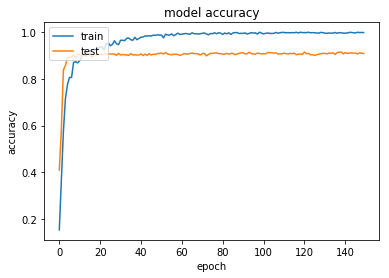

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loss single

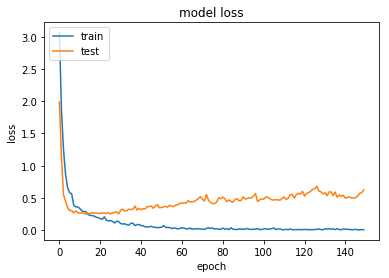

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Full report with confusion matrix

Accuracy : 0.9077102803738317

Classification Report
              precision    recall  f1-score   support

           0    0.87218   0.94309   0.90625       123
           1    0.94737   0.85714   0.90000        63
           2    0.96552   0.91803   0.94118        61
           3    0.81667   0.96078   0.88288        51
           4    0.80851   0.80000   0.80423        95
           5    0.90361   0.74257   0.81522       101
           6    0.88462   0.93878   0.91089        49
           7    0.97015   0.95588   0.96296        68
           8    0.91045   1.00000   0.95312        61
           9    0.96825   0.93846   0.95312        65
          10    0.97059   1.00000   0.98507        66
          11    0.96296   0.98113   0.97196        53

   micro avg    0.90771   0.90771   0.90771       856
   macro avg    0.91507   0.91966   0.91558       856
weighted avg    0.90943   0.90771   0.90664       856

[[116   0   0   0   4   3   0   0   0   0   0   0]
 [  0  54   0   1   0   0   2

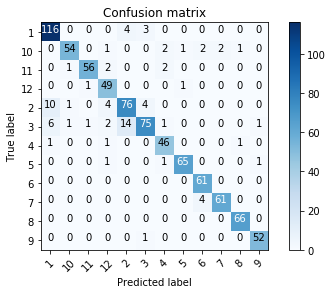

In [22]:
#should import labels directly from folder:
labels, _, _= get_labels("./audio")
labArray = []
for label in labels:
    labArray.append(label)

le = LabelEncoder()

le.fit_transform(labArray)

full_multiclass_report(model, X_test, y_test_hot, classes=le.inverse_transform(np.arange(12)))

## Loss and accuracy plot

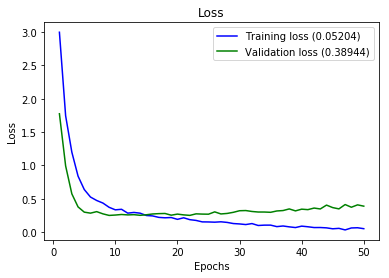

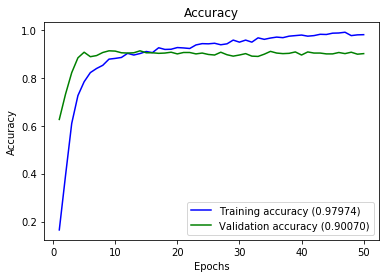

In [43]:
plot_history(history)

# Import / export models

to be created. See https://www.pyimagesearch.com/2018/12/10/keras-save-and-load-your-deep-learning-models/

# Functions for all the metrics and results

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

In [9]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()